# MNIST GPU Deep Learning Benchmark with H2O Deep Water
In reference to [Szilard's Benchmark-DL](https://github.com/szilard/benchm-dl)

![MNIST](images/mnist.png)

In [1]:
import sys, os
import os.path
import h2o
from h2o.estimators.deepwater import H2ODeepWaterEstimator
PATH = os.path.expanduser("~/h2o-3/")
h2o.init(nthreads=-1)
if not H2ODeepWaterEstimator.available(): exit

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_101"; Java(TM) SE Runtime Environment (build 1.8.0_101-b13); Java HotSpot(TM) 64-Bit Server VM (build 25.101-b13, mixed mode)
  Starting server from /home/ubuntu/h2o-3/build/h2o.jar
  Ice root: /tmp/tmpfl8udm
  JVM stdout: /tmp/tmpfl8udm/h2o_ubuntu_started_from_python.out
  JVM stderr: /tmp/tmpfl8udm/h2o_ubuntu_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster version:,3.11.0.99999
H2O cluster version age:,22 hours and 29 minutes
H2O cluster name:,H2O_from_python_ubuntu_ec17uh
H2O cluster total nodes:,1
H2O cluster free memory:,3.264 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


### Hardware check

In [2]:
!nvidia-smi

Tue Oct 25 20:15:50 2016       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 370.28                 Driver Version: 370.28                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GRID K520           Off  | 0000:00:03.0     Off |                  N/A |
| N/A   33C    P0     1W / 125W |      0MiB /  4036MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Data preparation

In [3]:
train = h2o.import_file(PATH + "bigdata/laptop/mnist/train.csv.gz")
predictors  = list(range(0,784))
resp        = 784

train[predictors] = train[predictors]/255.0
train[resp] = train[resp].asfactor()
nclasses    = train[resp].nlevels()[0]

Parse progress: |█████████████████████████████████████████████████████████| 100%


### Define the model architecture

In [4]:
def cnn(num_classes):
    import mxnet as mx
    data    = mx.symbol.Variable('data')

    conv1   = mx.symbol.Convolution(data=data, kernel=(4,4), num_filter=32)
    relu1   = mx.symbol.Activation(data=conv1, act_type="relu")
    pool1   = mx.symbol.Pooling(data=relu1, pool_type="max", kernel=(2,2), stride=(2,2))

    conv2   = mx.symbol.Convolution(data=pool1, kernel=(3,3), num_filter=16)
    relu2   = mx.symbol.Activation(data=conv2, act_type="relu")
    pool2   = mx.symbol.Pooling(data=relu2, pool_type="max", kernel=(2,2), stride=(2,2))
    drop    = mx.symbol.Dropout(data=pool2, p=0.2)

    flatten = mx.symbol.Flatten(data=drop)
    fc1     = mx.symbol.FullyConnected(data=flatten, num_hidden=128)
    relu3   = mx.symbol.Activation(data=fc1, act_type="relu")

    fc2     = mx.symbol.FullyConnected(data=relu3, num_hidden=64)
    relu4   = mx.symbol.Activation(data=fc2, act_type="relu")

    fc3     = mx.symbol.FullyConnected(data=relu4, num_hidden=num_classes)
    net     = mx.symbol.SoftmaxOutput(data=fc3, name='softmax')
    return net
cnn(nclasses).save("/tmp/cnn.json")

### Train the model

In [16]:
model = H2ODeepWaterEstimator(
    epochs=10,
    learning_rate=0.05,
    learning_rate_annealing=1e-5,
    momentum_start=0.9,
    momentum_stable=0.9,
    mini_batch_size=128,
    network_definition_file="/tmp/cnn.json",
    image_shape=[28,28],                ## MNIST is 28x28 pixels
    channels=1,                         ## monochrome
    device_id=[0],                      ## select which GPU to use
    gpu=True,                           ## disable to compare to CPU
    standardize=False,                  ## data was manually scaled to 0..1
    ignore_const_cols=False,            ## include all pixels even though some are always 0
    seed=1234                           ## for reproducibility
    #,score_duty_cycle=0                ## no scoring until the end
)
                              
model.train(x=predictors,y=resp, training_frame=train)

deepwater Model Build progress: |█████████████████████████████████████████| 100%


### Inspect the model

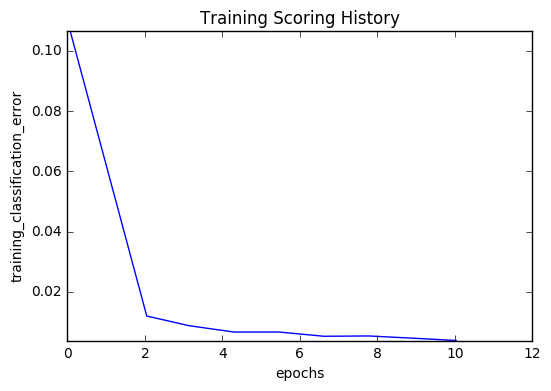

In [17]:
model.plot()

In [18]:
model.show()

Model Details
H2ODeepWaterEstimator :  Deep Water
Model Key:  DeepWater_model_python_1477426546266_3
Status of Deep Learning Model: user, 261.3 KB, predicting C785, 10-class classification, 602,112 training samples, mini-batch size 128



,input_neurons,rate,momentum
,784,0.0071214,0.9




ModelMetricsMultinomial: deepwater
** Reported on train data. **

MSE: 0.00350647507698
RMSE: 0.0592154969326
LogLoss: 0.013430018741
Mean Per-Class Error: 0.00381900174444
Confusion Matrix: vertical: actual; across: predicted



0,1,2,3,4,5,6,7,8,9,Error,Rate
992.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0020121,2 / 994
0.0,1112.0,0.0,0.0,3.0,0.0,1.0,2.0,0.0,0.0,0.0053667,"6 / 1,118"
0.0,2.0,965.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0030992,3 / 968
0.0,0.0,0.0,993.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0040120,4 / 997
0.0,1.0,0.0,0.0,991.0,0.0,0.0,0.0,0.0,4.0,0.0050201,5 / 996
0.0,1.0,1.0,0.0,0.0,884.0,1.0,0.0,2.0,0.0,0.0056243,5 / 889
1.0,0.0,0.0,0.0,0.0,0.0,994.0,0.0,1.0,0.0,0.0020080,2 / 996
0.0,0.0,0.0,0.0,2.0,0.0,0.0,997.0,0.0,1.0,0.003,"3 / 1,000"
0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1034.0,0.0,0.0028930,"3 / 1,037"
1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,965.0,0.0051546,5 / 970


Top-10 Hit Ratios: 


k,hit_ratio
1,0.9961867
2,0.9995986
3,0.9998997
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0
10,1.0


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_classification_error
,2016-10-25 20:20:05,0.000 sec,None,0.0,0,0.0,nan,nan,nan
,2016-10-25 20:20:06,2.000 sec,7148 obs/sec,0.0682667,1,4096.0,0.3078531,0.3413932,0.1067737
,2016-10-25 20:20:18,13.680 sec,10188 obs/sec,2.048,30,122880.0,0.1010047,0.0373182,0.0119418
,2016-10-25 20:20:24,18.698 sec,11160 obs/sec,3.1402667,46,188416.0,0.0864132,0.0290418,0.0087306
,2016-10-25 20:20:29,23.834 sec,11831 obs/sec,4.3008,63,258048.0,0.0759970,0.0227918,0.0066232
,2016-10-25 20:20:34,28.917 sec,12274 obs/sec,5.4613333,80,327680.0,0.0725951,0.0195389,0.0066232
,2016-10-25 20:20:39,33.973 sec,12594 obs/sec,6.6218667,97,397312.0,0.0647291,0.0162194,0.0052183
,2016-10-25 20:20:44,39.002 sec,12834 obs/sec,7.7824,114,466944.0,0.0638558,0.0154559,0.0053186
,2016-10-25 20:20:49,44.279 sec,13039 obs/sec,9.0112,132,540672.0,0.0613183,0.0138903,0.0045158
,2016-10-25 20:20:54,48.732 sec,13168 obs/sec,10.0352,147,602112.0,0.0592155,0.0134300,0.0038133


In [19]:
model.scoring_history()

,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_classification_error
0,,2016-10-25 20:20:05,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN
1,,2016-10-25 20:20:06,2.000 sec,7148 obs/sec,0.068267,1,4096.0,0.307853,0.341393,0.106774
2,,2016-10-25 20:20:18,13.680 sec,10188 obs/sec,2.048000,30,122880.0,0.101005,0.037318,0.011942
3,,2016-10-25 20:20:24,18.698 sec,11160 obs/sec,3.140267,46,188416.0,0.086413,0.029042,0.008731
4,,2016-10-25 20:20:29,23.834 sec,11831 obs/sec,4.300800,63,258048.0,0.075997,0.022792,0.006623
5,,2016-10-25 20:20:34,28.917 sec,12274 obs/sec,5.461333,80,327680.0,0.072595,0.019539,0.006623
6,,2016-10-25 20:20:39,33.973 sec,12594 obs/sec,6.621867,97,397312.0,0.064729,0.016219,0.005218
7,,2016-10-25 20:20:44,39.002 sec,12834 obs/sec,7.782400,114,466944.0,0.063856,0.015456,0.005319
8,,2016-10-25 20:20:49,44.279 sec,13039 obs/sec,9.011200,132,540672.0,0.061318,0.013890,0.004516
9,,2016-10-25 20:20:54,48.732 sec,13168 obs/sec,10.035200,147,602112.0,0.059215,0.013430,0.003813


### Let's evaluate the test set performance

In [20]:
test = h2o.import_file(PATH + "bigdata/laptop/mnist/test.csv.gz")
test[predictors] = test[predictors]/255.0
test[resp] = test[resp].asfactor()

print(model.model_performance(test))

Parse progress: |█████████████████████████████████████████████████████████| 100%

ModelMetricsMultinomial: deepwater
** Reported on test data. **

MSE: 0.00638824324211
RMSE: 0.0799264864867
LogLoss: 0.0236557898302
Mean Per-Class Error: 0.00761628910257
Confusion Matrix: vertical: actual; across: predicted



0,1,2,3,4,5,6,7,8,9,Error,Rate
976.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0040816,4 / 980
0.0,1133.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0017621,"2 / 1,135"
2.0,0.0,1025.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0067829,"7 / 1,032"
0.0,0.0,1.0,1002.0,0.0,3.0,0.0,0.0,2.0,2.0,0.0079208,"8 / 1,010"
0.0,0.0,1.0,0.0,978.0,0.0,1.0,0.0,0.0,2.0,0.0040733,4 / 982
2.0,0.0,0.0,5.0,0.0,881.0,1.0,0.0,1.0,2.0,0.0123318,11 / 892
4.0,2.0,0.0,0.0,2.0,1.0,948.0,0.0,1.0,0.0,0.0104384,10 / 958
0.0,3.0,4.0,0.0,0.0,0.0,0.0,1018.0,2.0,1.0,0.0097276,"10 / 1,028"
0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,968.0,2.0,0.0061602,6 / 974
0.0,1.0,0.0,0.0,7.0,1.0,0.0,4.0,0.0,996.0,0.0128840,"13 / 1,009"


Top-10 Hit Ratios: 


k,hit_ratio
1,0.9925
2,0.999
3,0.9997
4,0.9999
5,0.9999
6,1.0
7,1.0
8,1.0
9,1.0
10,1.0


In [21]:
h2o.download_all_logs("/tmp/")

Writing H2O logs to /tmp/h2ologs_20161025_082151.zip


u'/tmp/h2ologs_20161025_082151.zip'